In [1]:
# importing all basic required library
import os
import sys
import numpy as np

# importing neural network related library
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.models import Model

# importing KNN algo library
from annoy import AnnoyIndex

# importing plotting library
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline



Using TensorFlow backend.


In [2]:
# Importing RESNET50 model from keras applications.
base_model = ResNet50(weights='imagenet')
# Using base model reconstructing a New mode which input will be my baemodel input and output will be 2nd last layer.
# (2nd last layer in Resnet is last pooling block which give a fixed 2048 embedding feature vectors for any image input)
model = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)



Instructions for updating:
Colocations handled automatically by placer.


In [3]:
# printing model summary
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [4]:
# extracting a feature vector for a given image path
def extract_features(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    feature = model.predict(x)[0]
    return feature

In [5]:
# Annoy Indexing function
# This function will take ```no of similar items you want, target feature vector, all available feature vectors or database.
# Here Flag is for building an annoy indexed file or not




def _index_and_search(k, target, pool, flag=False):
    xb = []  # array to be indexed
    xb = list(pool)

    if target not in xb:
        xb.append(target)
    d = 2048
    nb = len(xb)  # database size
    nq = 1  # nb of queries
    if flag:
        annoy_index(d, xb)

    xq = 0
    query_vector = target

    try:
        xq = xb.index(query_vector)
    except:
        xb.append(query_vector)
        xq = xb.index(query_vector)
    I = annoy_search(xq, 'annoy_index.ann', k, d)  # search results

    return explain_result(I)


def get_value_for_key(key, object):
    if key in object:
        return object[key]
    else:
        return ""


def annoy_index(d, xb):
    t = AnnoyIndex(d)  # Length of item vector that will be indexed
    for i, x in enumerate(xb):
        t.add_item(i, x)

    t.build(20)
    t.save('annoy_index.ann')


def annoy_search(xq, index, k, d):
    u = AnnoyIndex(d)
    u.load(index)
    I = u.get_nns_by_item(xq, k, include_distances=True)
    return I


def explain_result(I):
    return {"message": I}


In [6]:
# plotting any image


def plot_image(target_image):
    plt.figure(figsize=(3.5,3.5))
    plt.imshow(plt.imread(target_image))
    return plt.show()


In [7]:
# plotting list of images horizontally

def plot_image_horizontal(images):
    images = [mpimg.imread(img_path) for img_path in images]
    plt.figure(figsize=(10,10))
    columns = 5
    for i, image in enumerate(images):
        plt.subplot(len(images) / columns + 1, columns, i + 1)
        plt.imshow(image)

In [8]:
# It will take input as the item index,  list of all features, array where it will store the similar group items and their distances, an array which will store what all items it has checked a lot
def get_closest_images(index, all_features, similar_groups=[] , checked_data=[], distance_cutoff=0.60):
    target_product_feature = all_features[index]
    results = _index_and_search(5, target_product_feature, all_features, flag=True)["message"]
    results_index = results[0]
    results_distance = results[1]
    
    similar_items = []
    similar_distances = []
    
    for i in range(len(results_distance)):
        if results_distance[i] <= distance_cutoff:
            similar_items.append(results_index[i])
            similar_distances.append(results_distance[i])
        else: pass
        
    if len(similar_items)<= 1 :
            similar_items += results_index[len(similar_items):2]
            
            
    similar_groups.append([similar_items, similar_distances])
    checked_data += similar_items
    
    
    return similar_groups, checked_data
    
    

In [9]:
# reading all images
product_images = os.listdir("pics/")
# getting all features
product_features = [extract_features("pics/"+i).tolist() for i in product_images]

In [11]:
# grouping all images
similar_product_groups = [] 
checked_product_data = []
for i in range(len(product_images)):
    if i not in checked_product_data:
        similar_product_groups, checked_product_data = get_closest_images(i, product_features, similar_product_groups, checked_product_data)
    else:pass

/home/opensource/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
/home/opensource/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.


In [12]:
# All similar groups with their distance
similar_product_groups

[[[0, 7, 5], [0.0, 0.4642280340194702, 0.5686545968055725]],
 [[1, 4, 6], [0.0, 0.44967931509017944, 0.5465850830078125]],
 [[2, 3, 19, 13],
  [0.0, 0.5062429904937744, 0.520771861076355, 0.5786921381950378]],
 [[8, 12], [0.0, 0.5690045356750488]],
 [[9, 17, 11], [0.0, 0.3552713692188263, 0.5584215521812439]],
 [[10, 14, 16], [0.0, 0.472552090883255, 0.5181432962417603]],
 [[15, 7], [0.0]],
 [[18, 12], [0.0, 0.5915802717208862]]]

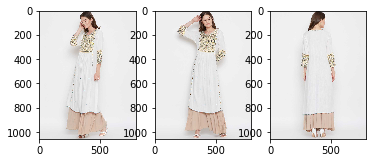

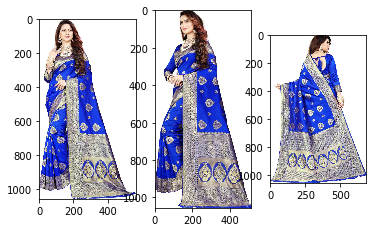

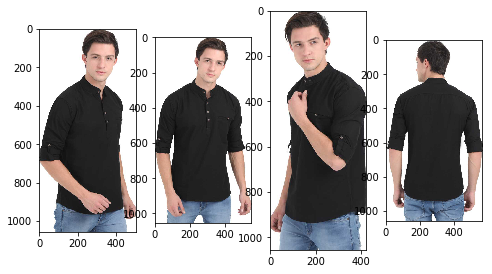

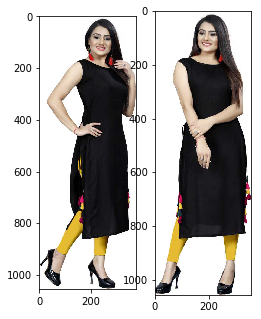

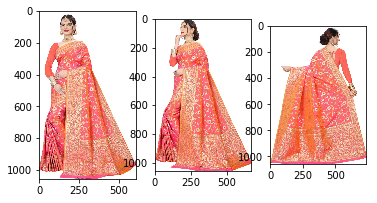

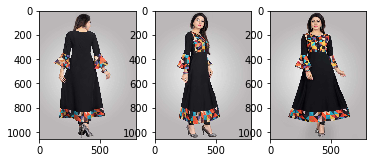

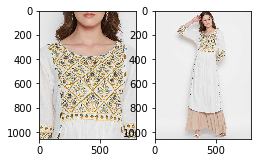

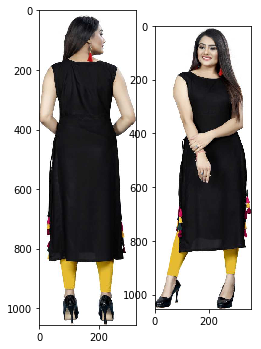

In [13]:
# plotting all similar_groups
for similar_group in similar_product_groups:
#     print("=============================================")
    plot_image_horizontal(["pics/"+product_images[i] for i in similar_group[0]])
#     for j in i[0]:
#         plot_image("pics/"+product_images[j])